In [1]:
from mlflow.tracking.client import MlflowClient
from mlflow.entities import ViewType
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import mlflow
import os
from scipy.special import softmax
from sklearn.metrics import confusion_matrix, classification_report
sns.set(color_codes=True)
%matplotlib inline
mlflow.set_tracking_uri("file:/data/logs/kristian/mlruns")

import matplotlib

matplotlib.rcParams.update({
    'font.family': 'serif',
    'text.usetex': True,
})


labels = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
WP = "params.quantization/weight_precision"
AP = "params.quantization/activation_precision"


In [2]:
experiments = [
    #{'id': "10", 'train_id': "3", 'name': 'resnet18' }, 
    
    {'id': "7", 'train_id': "7", 'name': 'lenet' }, 
    {'id': "11", 'name': 'lenetplus' },
    {'id': "14", 'train_id': "8", 'name': 'squeezenet' }, 
]

In [3]:
resnet = mlflow.search_runs(
    experiment_ids="10",
    filter_string="tags.stage = 'eval'",
    output_format="pandas",
)
resnet2 = mlflow.search_runs(
    experiment_ids="3",
    filter_string="tags.stage = 'eval'",
    output_format="pandas",
)
resnet = pd.concat([resnet, resnet2])

ens = mlflow.search_runs(
    experiment_ids="19",
    filter_string="tags.stage = 'eval'",
    output_format="pandas",
)


In [4]:
results = []
quant = resnet[resnet["tags.type"] == "quantization"]
quant = quant[quant[AP] == "7"]

# for i in range(len(quant)):
#     run = quant.iloc[i]
#     result = {"type": 'Quantization', 'Absolute Size': int(run["params.model/params_trainable"]) * int(run[WP]), 'Accuacy': run["metrics.q_test/acc"]}
#     results.append(result)

# prun_quant = resnet[resnet["tags.type"] == "pruning + quantization"]
# for i in range(len(prun_quant)):
#     run = prun_quant.iloc[i]

#     result = {"type": 'Quantization & Pruning', 'Absolute Size': int(run["params.model/params_trainable"]) * int(run[WP]) * 0.25, 'Accuracy': run["metrics.q_test/acc"]}
#     results.append(result)


In [5]:
ens_res = []
quant = ens[ens["tags.type"] == "ensemble + quantization"]
quant = quant[quant[AP] == "7"]
for i in range(len(quant)):
    run = quant.iloc[i]
    result = {"type": 'Quantization', 'Absolute Size': int(
        run["params.model/params_trainable"]) * int(run[WP]), 'Accuracy': run["metrics.q_test/acc"]}
    results.append(result)

prun_quant = ens[ens["tags.type"] == "ensemble + quantization + pruning"]
for i in range(len(prun_quant)):
    run = prun_quant.iloc[i]
    result = {"type": 'Pruning Quantization', 'Absolute Size': int(
        run["params.model/params_trainable"]) * int(run[WP]) * 0.25, 'Accuracy': run["metrics.q_test/acc"]}
    results.append(result)


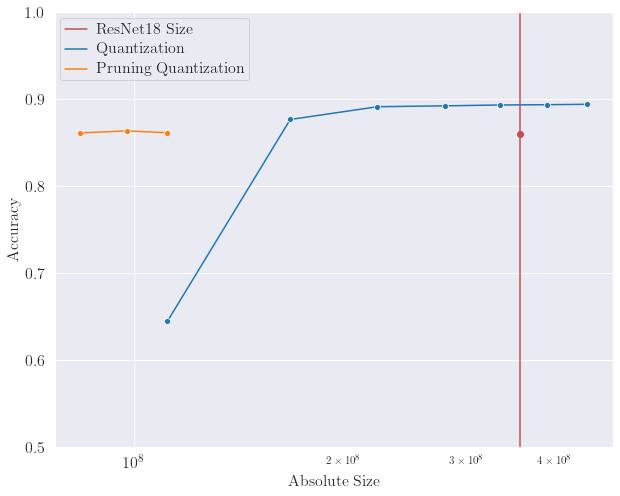

In [12]:
df = pd.DataFrame(results)
fig, ax = plt.subplots(figsize=(10,8))
sns.set_palette("tab10")

# resnet
rn = resnet[resnet["tags.type"] == "eval"].iloc[0]
rn_size = int(rn["params.model/params_trainable"])*32
plt.axvline(x=rn_size, label="ResNet18 Size", c=sns.get_)
plt.plot(rn_size, rn["metrics.test/acc"],"or")

ern = ens[ens["tags.type"] == "ensemble"].iloc[0]
ern_size = int(ern["params.model/params_trainable"])*32
#plt.plot(ern_size, ern["metrics.test/acc"],"og")
#plt.axvline(x=11181642*32*5, label="ResNet18 Ensemble Size", c="g")

grid = sns.lineplot(data=df, x="Absolute Size", y="Accuracy", hue="type", dashes=False, marker="o")
grid.set(xscale="log")

plt.ylim(0.5, 1)

grid.set_xlabel("Absolute Size", fontsize=16)
grid.set_ylabel("Accuracy", fontsize=16)
grid.tick_params(labelsize=16)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[0:], labels=labels[0:])
plt.setp(ax.get_legend().get_texts(), fontsize=16)

#df = pd.DataFrame(ens_res)
#sns.lineplot(data=df, x="abs_size", y="acc",  hue="type", dashes=False, palette="tab20")
plt.savefig('/home/k.schwienbacher/quantization-robustness/data/ensemble/ensemble-comp-log.pdf', bbox_inches="tight")


In [26]:
data = [
    {"pruning": "unstructured\_l1", "accuracy": 0.82, "amount": 0.5},
    {"pruning": "unstructured\_l1", "accuracy": 0.80, "amount": 0.75},
    {"pruning": "unstructured\_l1", "accuracy": 0.81, "amount": 0.875},
    {"pruning": "unstructured\_l1", "accuracy": 0.81, "amount": 0.9475},
    {"pruning": "unstructured\_random", "accuracy": 0.80, "amount": 0.5},
    {"pruning": "unstructured\_random", "accuracy": 0.78, "amount": 0.75},
    {"pruning": "unstructured\_random", "accuracy": 0.75, "amount": 0.875},
    {"pruning": "unstructured\_random", "accuracy": 0.7, "amount": 0.9475},
    
    {"pruning": "structured\_random", "accuracy": 0.5, "amount": 0.5},
    {"pruning": "structured\_random", "accuracy": 0.33, "amount": 0.75},
    {"pruning": "structured\_random", "accuracy": 0.18, "amount": 0.875},
    {"pruning": "structured\_random", "accuracy": 0.16, "amount": 0.9475},
    {"pruning": "structured\_l1", "accuracy": 0.5, "amount": 0.5},
    {"pruning": "structured\_l1", "accuracy": 0.33, "amount": 0.75},
    {"pruning": "structured\_l1", "accuracy": 0.19, "amount": 0.875},
    {"pruning": "structured\_l1", "accuracy": 0.16, "amount": 0.9475},
]

df = pd.DataFrame(data)


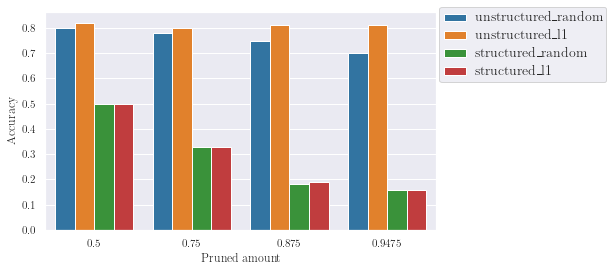

In [43]:
fig, ax = plt.subplots(figsize=(7, 4))
sns.set_palette("tab10")

grid = sns.barplot(data=df, x="amount", y="accuracy", hue="pruning")

grid.set_xlabel("Pruned amount")
grid.set_ylabel("Accuracy")
handles, labels2 = ax.get_legend_handles_labels()
ax.legend(handles=handles[0:], labels=labels2[0:])
grid.legend(loc='upper right', bbox_to_anchor=(1.45, 1.05), ncol=1)
plt.setp(ax.get_legend().get_texts(), fontsize=14)


plt.savefig('/home/k.schwienbacher/quantization-robustness/data/pruning/pruning_method_comp.pdf', bbox_inches="tight")
